In [1]:
include("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env/env.jl")

  Activating project at `~/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env`
    Updating registry at `~/.julia/registries/General.toml`
   Installed ImageMagick ───── v1.4.0
   Installed ImageMagick_jll ─ v7.1.1+1
    Updating `~/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env/Project.toml`
  [336ed68f] + CSV v0.10.14
  [324d7699] + CategoricalArrays v0.10.8
  [a93c6f00] + DataFrames v1.7.0
  [31c24e10] + Distributions v0.25.112
  [5789e2e9] + FileIO v1.16.4
  [48062228] + FilePathsBase v0.9.22
  [d7ba0133] + Git v1.3.1
  [916415d5] + Images v0.26.1
  [429524aa] + Optim v1.9.4
  [6f49c342] + RCall v0.14.6
  [f2b01f46] + Roots v2.2.1
  [0f1e0344] + WebIO v0.8.21
    Updating `~/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [7d9f7c33] + Accessors v0.1.38
  [79e6a3ab] + Adapt v4.0.4
  [66dad0bd] + AliasTables v1.1.3
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.16.0
  [bf4720bc] +


The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//RtmpHBun4J/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/hrbrthemes_0.8.7.tgz'
│ Content type 'application/x-gzip' length 862799 bytes (

"Julia and R setup complete"

In [2]:
# inputs

#path to haplotypes file created from the VeTrans output
haps_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/F/F_prev_in/Inference_23_5678.out"

#path to the Times.in file
times_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#path to Blanche output file
blanche_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_19_haplotypes.dat"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [3]:
# Read the times file to get the numeric column headers
times = readlines(times_path)  # Read lines directly from the file path
numeric_column_headers = parse.(Int, times)  # Times file contains integers

# Read the .out file, skipping the first metadata line
haps_lines = readlines(haps_path)[2:end]  # Skip the first metadata line

# Split the lines into Haplotype (first column) and numeric values (rest of the columns)
haps_data = [split(line) for line in haps_lines]
haplotypes = [row[1] for row in haps_data]
numeric_values = [parse.(Float64, row[2:end]) for row in haps_data]

# Create a DataFrame with the "Haplotype" column first
haps_wide = DataFrame(Haplotype = haplotypes)

# Add numeric columns to the DataFrame
for (i, header) in enumerate(numeric_column_headers)
    haps_wide[!, Symbol(header)] = [row[i] for row in numeric_values]
end

# Display the DataFrame
println(haps_wide)

24×11 DataFrame
 Row │ Haplotype                   1            29           50           74           83           99           111          119          125         140         
     │ SubStrin…                   Float64      Float64      Float64      Float64      Float64      Float64      Float64      Float64      Float64     Float64     
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACAGCAACAAAGA  0.327903     0.740676     0.885817     1.0e-10      0.3982       0.00345555   1.0e-10      0.227683     1.0e-10     0.0663929
   2 │ GAGCCCCCGAGAGACAACAACAAAGA  1.0e-10      1.0e-10      1.00005e-10  0.00971951   0.000631292  0.0221088    1.0e-10      1.0e-10      1.0e-10     1.0e-10
   3 │ AAGCCCCCGAGAAACAATAACAAAGA  1.0e-10      1.0e-10      1.00005e-10  1.0e-10      1.0e-10      1.00281e-10  1.0e-10      1.0e-10      0.182113    1.0e-10
   4 │ GGGCTT

In [4]:
# pass into R
@rput haps_wide 

R"""
library(tidyverse)

times <- colnames(haps_wide)[-1]

haps <- haps_wide %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCGAGAAACAGCAACAAAGA,1,0.327903
2,GGGCCCCCGAGAAACAGCAACAAAGA,29,0.740676
3,GGGCCCCCGAGAAACAGCAACAAAGA,50,0.885817
4,GGGCCCCCGAGAAACAGCAACAAAGA,74,1.0e-10
5,GGGCCCCCGAGAAACAGCAACAAAGA,83,0.3982
6,GGGCCCCCGAGAAACAGCAACAAAGA,99,0.00345555
7,GGGCCCCCGAGAAACAGCAACAAAGA,111,1.0e-10
8,GGGCCCCCGAGAAACAGCAACAAAGA,119,0.227683
9,GGGCCCCCGAGAAACAGCAACAAAGA,125,1.0e-10


In [5]:
# zero out smallest frequencies

@rput haps 

# R code to transform the Frequency column
R"""
library(tidyverse)

haps <- haps %>%
  mutate(Frequency = ifelse(Frequency <= 10e-10, 0, Frequency))
"""

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCGAGAAACAGCAACAAAGA,1,0.327903
2,GGGCCCCCGAGAAACAGCAACAAAGA,29,0.740676
3,GGGCCCCCGAGAAACAGCAACAAAGA,50,0.885817
4,GGGCCCCCGAGAAACAGCAACAAAGA,74,0.0
5,GGGCCCCCGAGAAACAGCAACAAAGA,83,0.3982
6,GGGCCCCCGAGAAACAGCAACAAAGA,99,0.00345555
7,GGGCCCCCGAGAAACAGCAACAAAGA,111,0.0
8,GGGCCCCCGAGAAACAGCAACAAAGA,119,0.227683
9,GGGCCCCCGAGAAACAGCAACAAAGA,125,0.0


In [6]:
# establish the consensus haplotype at time 0

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [7]:
using DataFrames

# Path to the single_locus_trajectories file
sl_traj_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/single_locus_trajectories/by_protein/single_locus_trajectories10_F_Fusion_protein.out"

# Assuming haps is already loaded as a DataFrame
# Extract the unique values from the Haplotype column
names = unique(haps.Haplotype)

# Convert these unique values to a DataFrame
names_df = DataFrame(Haplotype = names)

# Define the function to create the loci DataFrame
function create_base_loci(filepath::String, consensus::String, names::DataFrame)
    # Initialize an empty Set to store unique first column integers
    first_column_set = Set{Int}()

    # Open the file and read each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Split the line by spaces and convert the first element to an integer
            push!(first_column_set, parse(Int, split(line)[1]))
        end
    end

    # Convert the Set to a sorted vector to create a DataFrame
    first_column_vector = sort(collect(first_column_set))
    
    # Check that the length of the consensus string matches the number of unique loci
    if length(first_column_vector) != length(consensus)
        error("The length of the consensus string must match the number of unique loci.")
    end

    # Create a DataFrame with the extracted unique integers and the consensus_base
    loci = DataFrame(locus = first_column_vector, consensus_base = collect(consensus))
    
    # Iterate over each row in the names DataFrame
    for row in eachrow(names)
        haplotype_string = row[:Haplotype]  # Get the sequence string from the Haplotype column
        column_name = Symbol(haplotype_string)  # Use the haplotype string as the column name

        # Initialize the new column with empty strings
        new_column = Vector{Union{Char, Nothing}}(nothing, length(loci.consensus_base))

        # Fill the new column, skipping matches with the consensus
        for j in 1:length(haplotype_string)
            if haplotype_string[j] != loci.consensus_base[j]
                new_column[j] = haplotype_string[j]
            end
        end

        # Add the new column to the loci DataFrame
        loci[!, column_name] = new_column
    end
    
    return loci
end

# Load the first row of the single_locus_trajectories file
loci = create_base_loci(sl_traj_path, consensus, names_df)

loci


Row,locus,consensus_base,GGGCCCCCGAGAAACAGCAACAAAGA,GAGCCCCCGAGAGACAACAACAAAGA,AAGCCCCCGAGAAACAATAACAAAGA,GGGCTTTCGAGAAACAATAATAAAGA,GGGCTCCCGGGAAAAAGCATCGAGAA,GATCCCTCGAGAAACAACAATGAAGG,GAGCCCCCGAGAAACTACAACAAAGA,GGGTCCTCGAGCAACAACAACAAAAA,GGGCCCCCGGGAAACAACAACAAAGA,GGTCCCTCGAGAAACAACAACAAAAA,GGGTCCCCGAGCAACAACAAGAGAAG,GGGCCCCCGAGAAACTACAACAAAGA,AGTCCTCTGGGCAACAATAACAGAAG,GGGCCCCTGAGGAACAACAACAAAGA,GGGCCCCCGAGAGACAACAATAGAGG,GGTCCCCCGAGCAACAGCAACAAAGA,GGGCCCCCGAGAAACAACAACAAAGA,GGGCCTCCGAGAAACAACATCAAAGA,GGGCCCCCGAGAAACAATAACAAAGA,GGGCCCCCGGGAAACAACAACAGAGA,GGGCCCCCGAGAGACTACAACAGAGG,GAGCCCTCGGGCAACTATAAGAGAGG,GGGTCCCCGAGAAACAACAACAAAGA,XXXXXXXXXXXXXXXXXXXXXXXXXX
,Int64,Char,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…
1,5778,G,,,A,,,,,,,,,,A,,,,,,,,,,,X
2,5882,G,,A,A,,,A,A,,,,,,,,,,,,,,,A,,X
3,5899,G,,,,,,T,,,,T,,,T,,,T,,,,,,,,X
4,5925,C,,,,,,,,T,,,T,,,,,,,,,,,,T,X
5,6005,C,,,,T,T,,,,,,,,,,,,,,,,,,,X
6,6148,C,,,,T,,,,,,,,,T,,,,,T,,,,,,X
7,6169,C,,,,T,,T,,T,,T,,,,,,,,,,,,T,,X
8,6223,C,,,,,,,,,,,,,T,T,,,,,,,,,,X
9,6280,G,,,,,,,,,,,,,,,,,,,,,,,,X


In [8]:
# create dataframe of variant positions per haplotype

# Melt the DataFrame to long format, excluding `locus` and `consensus_base`
melted = stack(loci, Not([:locus, :consensus_base]), variable_name=:haplotype, value_name=:variant_base)

# Define a function to check for undesired values
is_valid_variant(value) = !ismissing(value) && value ≠ "N/A" && value ≠ nothing

# Filter out rows where `variant_base` is missing, "N/A", or nothing
filtered = filter(row -> is_valid_variant(row.variant_base), melted)

# Select only relevant columns
variant_loci = filtered[:, [:locus, :consensus_base, :haplotype, :variant_base]]

# Create the 'variant' column by concatenating values
variant_loci.variant = string.(variant_loci.consensus_base) .* string.(variant_loci.locus) .* string.(variant_loci.variant_base)

# Filter for only helpful columns
variant_loci = variant_loci[:, [:haplotype, :variant]]

# Group by "haplotype" and concatenate "variant" values with newline separator
grouped = groupby(variant_loci, :haplotype)
variant_loci_merged = combine(grouped, :variant => (v -> join(v, "\n")))

# Rename the merged column
rename!(variant_loci_merged, :variant_function => :variant)

# Rename haplotype column for joining
rename!(variant_loci_merged, :haplotype => :Haplotype)

# join variant_loci to grouped_haps for annotation

haps = leftjoin(haps, variant_loci_merged, on=:Haplotype)

# Replace missing values in the 'variant' column with "Consensus"
haps.variant = coalesce.(haps.variant, "Consensus")

# Function to process each string in the 'variant' column
function replace_if_ends_with_x(text::String)
    words = split(text, '\n')
    if all(word -> endswith(word, "X"), words)
        return "X"
    else
        return text
    end
end

# Apply the function to the 'variant' column
haps.variant = map(replace_if_ends_with_x, haps.variant)

# print
println(haps)

240×4 DataFrame
 Row │ Haplotype                   Time    Frequency    variant                           
     │ String                      String  Float64      String                            
─────┼────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACAGCAACAAAGA  1       0.327903     A6518G
   2 │ GGGCCCCCGAGAAACAGCAACAAAGA  29      0.740676     A6518G
   3 │ GGGCCCCCGAGAAACAGCAACAAAGA  50      0.885817     A6518G
   4 │ GGGCCCCCGAGAAACAGCAACAAAGA  74      0.0          A6518G
   5 │ GGGCCCCCGAGAAACAGCAACAAAGA  83      0.3982       A6518G
   6 │ GGGCCCCCGAGAAACAGCAACAAAGA  99      0.00345555   A6518G
   7 │ GGGCCCCCGAGAAACAGCAACAAAGA  111     0.0          A6518G
   8 │ GGGCCCCCGAGAAACAGCAACAAAGA  119     0.227683     A6518G
   9 │ GGGCCCCCGAGAAACAGCAACAAAGA  125     0.0          A6518G
  10 │ GGGCCCCCGAGAAACAGCAACAAAGA  140     0.0663929    A6518G
  11 │ GAGCCCCCGAGAGACAACAACAAAGA  1       0.0          G5882A\nA6306G
  12 │ GAG

In [9]:
# generate variant_label column in Julia

# Function to format the variant column
function format_variant(variant::String)
    words = split(variant, r"\n")
    formatted_words = []
    
    for (i, word) in enumerate(words)
        push!(formatted_words, word)
        if i % 4 == 0 && i < length(words)
            push!(formatted_words, "\n")
        else
            push!(formatted_words, " ")
        end
    end
    
    return join(formatted_words, "")
end

# Apply the function to create the variant_label column
haps[:, "variant_label"] = format_variant.(haps.variant)

# Display the updated DataFrame
println(haps)

240×5 DataFrame
 Row │ Haplotype                   Time    Frequency    variant                            variant_label                     
     │ String                      String  Float64      String                             String                            
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACAGCAACAAAGA  1       0.327903     A6518G                             A6518G
   2 │ GGGCCCCCGAGAAACAGCAACAAAGA  29      0.740676     A6518G                             A6518G
   3 │ GGGCCCCCGAGAAACAGCAACAAAGA  50      0.885817     A6518G                             A6518G
   4 │ GGGCCCCCGAGAAACAGCAACAAAGA  74      0.0          A6518G                             A6518G
   5 │ GGGCCCCCGAGAAACAGCAACAAAGA  83      0.3982       A6518G                             A6518G
   6 │ GGGCCCCCGAGAAACAGCAACAAAGA  99      0.00345555   A6518G                             A6518G
   7 │ GGGCCCCCGAG

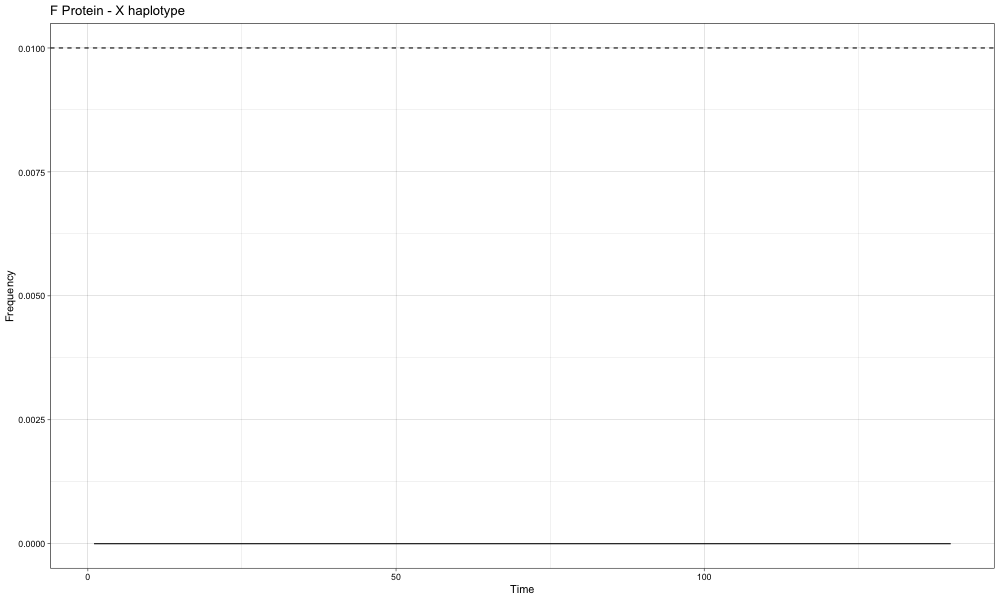

Temporary file deleted successfully.


In [10]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

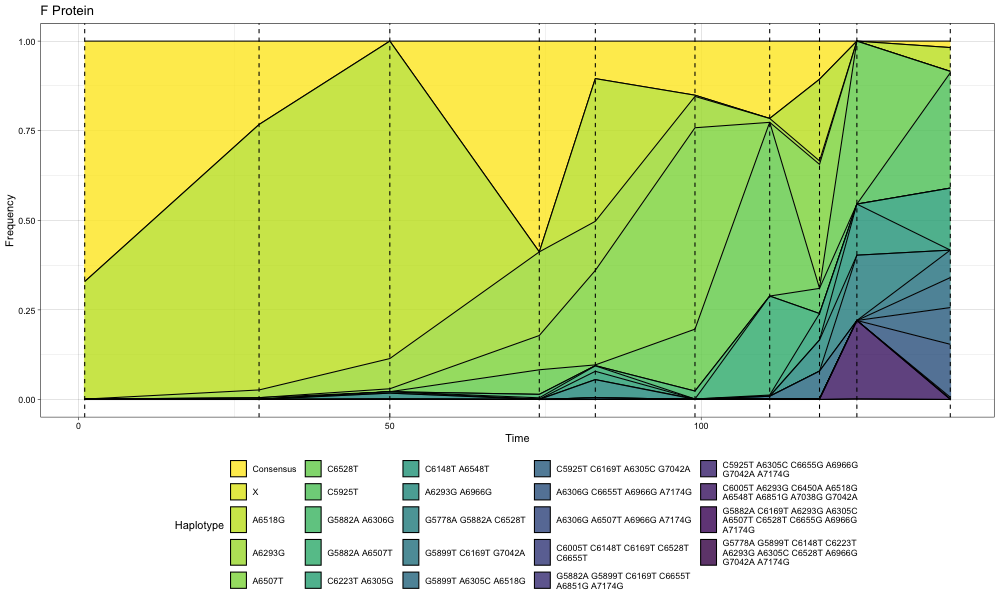

Temporary file deleted successfully.


In [11]:
# plot

@rput haps # pass back to R
@rput protein_name
@rput haps_path

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Identify the variant label with the highest frequency at the minimum time point
highest_freq_label <- haps %>%
  filter(Time == min(Time)) %>%
  arrange(desc(Frequency)) %>%
  slice(1) %>%
  pull(variant_label)

# Reorder variant_label: first the highest frequency, then by length
haps <- haps %>%
  mutate(variant_label = factor(variant_label,
                                levels = c(highest_freq_label, 
                                           unique(variant_label) %>% 
                                             setdiff(highest_freq_label) %>% 
                                             .[order(nchar(.))])
                                )
         )

# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(variant_label, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset, with many-to-many relationship allowed
haps <- haps %>%
  left_join(first_time_point, by = "variant_label", relationship = "many-to-many") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$variant_label))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = variant_label)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency", fill = "Haplotype") +
  theme(legend.position = "bottom", legend.spacing.x = unit(5, "lines")) +
  scale_fill_manual(values = haplotype_colors)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [12]:
# Function to calculate Hamming distance between two strings
function hamming_distance(s1::String, s2::String)::Int
    return sum(c1 != c2 for (c1, c2) in zip(s1, s2))
end

# Add new column with Hamming Distance
haps.ham_dist = [hamming_distance(row.Haplotype, consensus) for row in eachrow(haps)]

# Calculate the length of the consensus string
string_length = length(consensus)

# Filter out rows where ham_dist equals the string length
haps_filtered = haps[haps.ham_dist .!= string_length, :]

println(haps_filtered)

# Group the filtered DataFrame by the 'Mismatches' column
@rput haps_filtered
R"""
# Grouping by Time and ham_dist, then summing Frequency
haps_dist <- haps_filtered %>%
    group_by(Time, ham_dist) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_dist

230×6 DataFrame
 Row │ Haplotype                   Time    Frequency    variant                            variant_label                      ham_dist 
     │ String                      String  Float64      String                             String                             Int64    
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACAGCAACAAAGA  1       0.327903     A6518G                             A6518G                                    1
   2 │ GGGCCCCCGAGAAACAGCAACAAAGA  29      0.740676     A6518G                             A6518G                                    1
   3 │ GGGCCCCCGAGAAACAGCAACAAAGA  50      0.885817     A6518G                             A6518G                                    1
   4 │ GGGCCCCCGAGAAACAGCAACAAAGA  74      0.0          A6518G                             A6518G                                    1
   5 │ GGGCCCCCGAGAAACAGCAACAAAGA  8

Row,Time,ham_dist,Frequency
,String,Int64,Float64
1,1,0,0.671083
2,1,1,0.327903
3,1,2,0.000876709
4,1,3,0.000136765
5,1,4,0.0
6,1,5,0.0
7,1,6,0.0
8,1,8,0.0
9,1,9,0.0


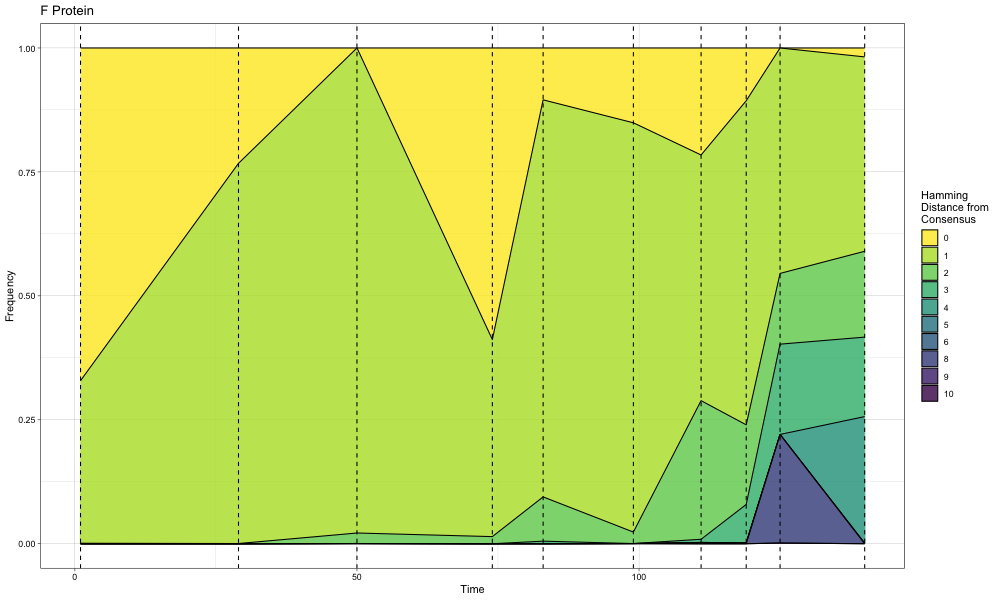

Temporary file deleted successfully.


In [13]:
# area plot for counts of mutations
# plot

@rput haps_dist # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types and ham_dist is an ordered factor
haps_dist$Frequency <- as.numeric(unlist(haps_dist$Frequency))
haps_dist$ham_dist <- factor(as.character(unlist(haps_dist$ham_dist)), levels = sort(unique(as.numeric(unlist(haps_dist$ham_dist)))))
haps_dist$Time <- as.numeric(unlist(haps_dist$Time))

# Plot with the ordered factor for ham_dist
p <- haps_dist %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = ham_dist)) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "Hamming\nDistance from\nConsensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end

The next plot requires input from Blanche (https://github.com/cjri/Blanche.git). 

In [14]:
# Read the .dat file and select the first two columns
df_coords = CSV.read(blanche_path, DataFrame; header=false, delim=" ", select=[1, 2])
names_df

using DataFrames

# Define a function to check if all characters in a string are 'X'
function all_Xs(s::String)
    return all(c -> c == 'X', s)
end

# Apply the function to create a boolean mask
mask = .!map(all_Xs, names_df.Haplotype)

# Filter the DataFrame using the mask
names_df = names_df[mask, :]


Row,Haplotype
,String
1,GGGCCCCCGAGAAACAGCAACAAAGA
2,GAGCCCCCGAGAGACAACAACAAAGA
3,AAGCCCCCGAGAAACAATAACAAAGA
4,GGGCTTTCGAGAAACAATAATAAAGA
5,GGGCTCCCGGGAAAAAGCATCGAGAA
6,GATCCCTCGAGAAACAACAATGAAGG
7,GAGCCCCCGAGAAACTACAACAAAGA
8,GGGTCCTCGAGCAACAACAACAAAAA
9,GGGCCCCCGGGAAACAACAACAAAGA


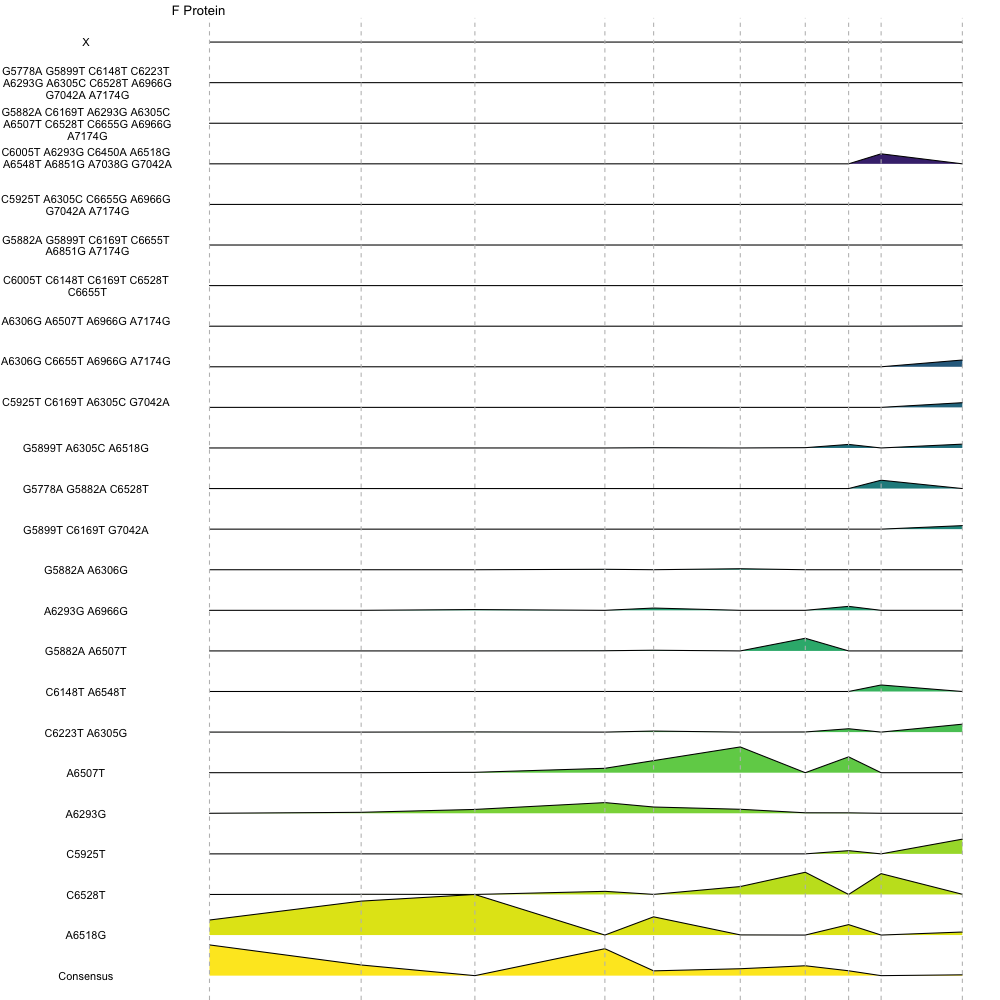

Temporary file deleted successfully.


In [36]:
@rput haps
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
# Function to add \n after every fourth word
add_newlines <- function(text) {
  words <- str_split(text, " ")[[1]]
  newline_text <- paste0(sapply(seq_along(words), function(i) {
    if (i %% 4 == 0) {
      paste0(words[i], "\n")
    } else {
      words[i]
    }
  }), collapse = " ")
  str_replace_all(newline_text, " \n", "\n")
}

# Create the variant_label column and modify it with newlines
haps <- haps %>%
  mutate(variant_label = ifelse(is.na(variant), "Consensus", gsub("\n", " ", variant))) %>%
  mutate(variant_label = sapply(variant_label, add_newlines))

# Find the frequency at the lowest time point and the timepoint of the highest Frequency
haps_freq_and_max_time <- haps %>%
  group_by(ham_dist, variant_label) %>%
  summarise(
    freq_at_min_time = Frequency[which.min(Time)], 
    max_time = min(Time[which.max(Frequency)]), 
    .groups = 'drop'
  )

# Sort by ham_dist, then by freq_at_min_time, and finally by max_time within each ham_dist group
haps_sorted <- haps %>%
  left_join(haps_freq_and_max_time, by = c("ham_dist", "variant_label")) %>%
  arrange(ham_dist, desc(freq_at_min_time), max_time)

# Ensure unique levels by removing duplicates
haps_sorted <- haps_sorted %>% distinct(variant_label, .keep_all = TRUE)

# Merge the sorted Haplotype order back into the main dataset
haps_arranged <- haps %>%
  mutate(variant_label = factor(variant_label, levels = haps_sorted$variant_label))

p <- ggplot(haps_arranged, aes(x = as.numeric(Time), y = variant_label, fill = variant_label)) +
  geom_density_ridges(aes(height = as.numeric(Frequency)), stat = "identity", scale = 1) +  # Adjust scale for closer ridges
  geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "grey") +
  theme_void() + 
  labs(title = protein_name, x = "Time", y = "Haplotype") +
  scale_fill_viridis(discrete = TRUE, direction = -1) +
  theme(legend.position = "none", 
        axis.text.y = element_text(hjust = 0.5))  # Center the y-axis text

png(filename = $output_path, width = 1000, height = 1000)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)
  
    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [16]:
# generate tree part of plot and extract variant order

# Pass metadata to R
@rput haps

# R code to generate plots
R"""
# Read the tree file
tree <- read.tree("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/iqtree/F_haplotypes/14/Consensus0_F_14_haplotypes_JC.treefile")

# Merge metadata with tree data, removing any rows with missing values and filtering out frequency = 0
tree_data <- ggtree::fortify(tree) %>% 
  left_join(haps, by = c("label" = "Haplotype")) %>%
  filter(Time == 1, Frequency > 0) %>%  # Filter out frequency = 0
  na.omit()  # Remove rows with missing values

# Define the max size for the points
max_point_size <- 10

# Extract the Time value (assuming it's consistent across all rows in tree_data)
time_value <- unique(tree_data$Time)

# Choose a color from the Viridis palette closer to the yellow end
selected_color <- viridis::viridis(1)  # Choose a color close to the yellow end of the spectrum

# Create the plot with scaled branch lengths and thinner lines
tree_plot <- ggtree(tree) %<+% tree_data +
  geom_tiplab(aes(label = ""), align = TRUE)

tree_order <- get_taxa_name(tree_plot)
"""

RObject{StrSxp}
 [1] "GAGCCCCCGAGCAACTACAACAAAGA" "GAGCCTCCGAGAAAATGCACCAAGGG"
 [3] "GGGCCCCCGAGAAACTACAACAAAGA" "GGTCCCTCGAGCAACAACAACAAAAA"
 [5] "GGTCCCCCGAGCAACAGCAACAAAGA" "GGGCCCCCGAGAAACAGCAACAAAGA"
 [7] "GGGCTCCCGAGAAAAAACATCGAAGA" "GGGCCCCCGGGAAACAACAACAAAGA"
 [9] "GGGCCCCCGAGAGACAACAACAAAGA" "GGGTCCCCGAGAAACAACAACAAAGA"
[11] "GGGCCCCCGAGAAACAATAACAAAGA" "GGGCCCCCAATAAGCAATAACAAAGG"
[13] "GGGCCCCTGAGGAACAACAATAGAGG" "GGGCCCCCGAGAAACAACAACAAAGA"


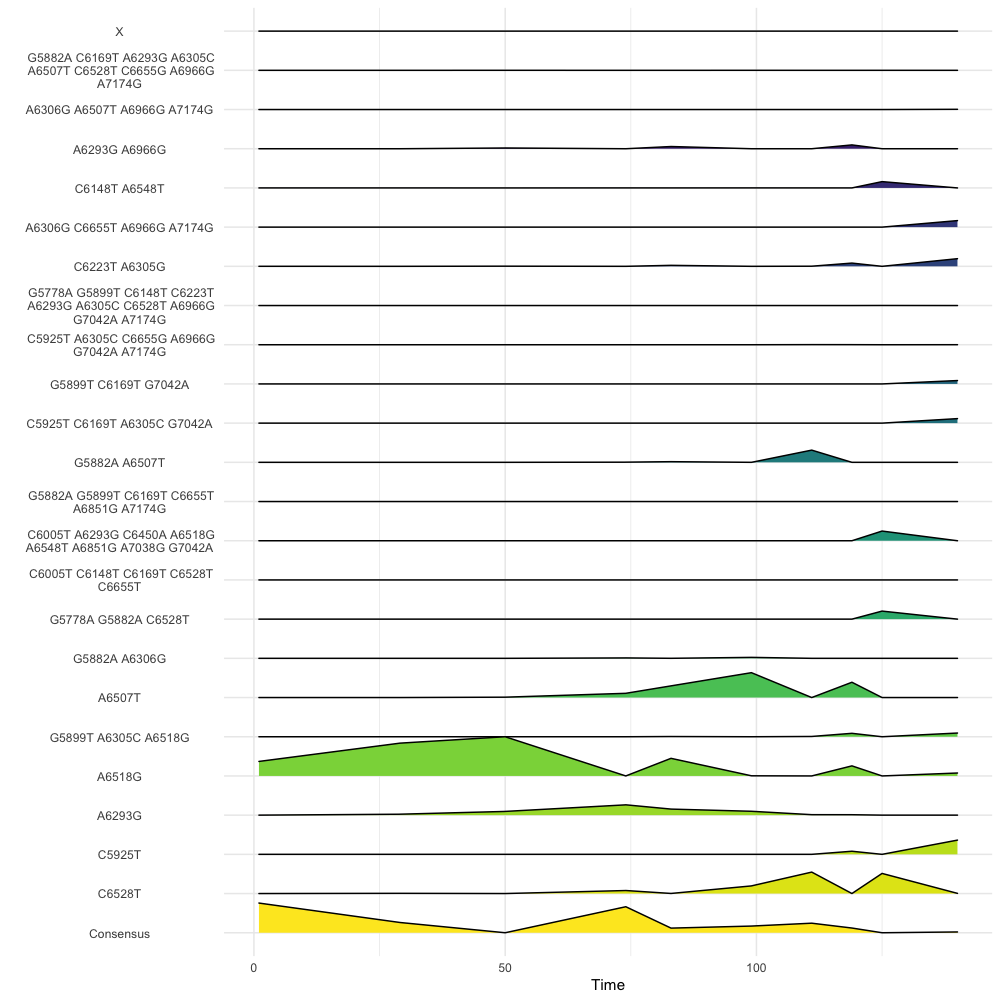

Temporary file deleted successfully.


In [34]:
# create ridgeplot for later joining

@rput haps
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")


R"""
# Ensure Haplotype is a character (in case it's a factor)
haps$Haplotype <- as.character(haps$Haplotype)

# Convert Haplotype to a factor with levels defined by tree_order, but in reverse order
haps$Haplotype <- factor(haps$Haplotype, levels = rev(tree_order))

# Reorder variant_label based on the reversed order of Haplotype
haps$variant_label <- factor(haps$variant_label, levels = unique(haps$variant_label[order(haps$Haplotype)]))

# Generate the plot
ridge_plot <- ggplot(haps, aes(x = as.numeric(Time), y = variant_label, fill = variant_label)) +
  geom_density_ridges(aes(height = as.numeric(Frequency)), stat = "identity", scale = 1) +  # Adjust scale for closer ridges
  theme_minimal() + 
  labs(x = "Time", y = "") +
  scale_fill_viridis(discrete = TRUE, direction = -1) +
  theme(legend.position = "none", 
        axis.text.y = element_text(hjust = 0.5))  # Center the y-axis text

# Save the plot with adjusted resolution and dimensions
png(filename = $output_path, width = 1000, height = 1000, res = 100)
print(ridge_plot)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
  img = load(output_path)
  display(img)

  # Delete the temporary image file after displaying
  rm(output_path; force = true)
  println("Temporary file deleted successfully.")
else
  println("File does not exist.")
end

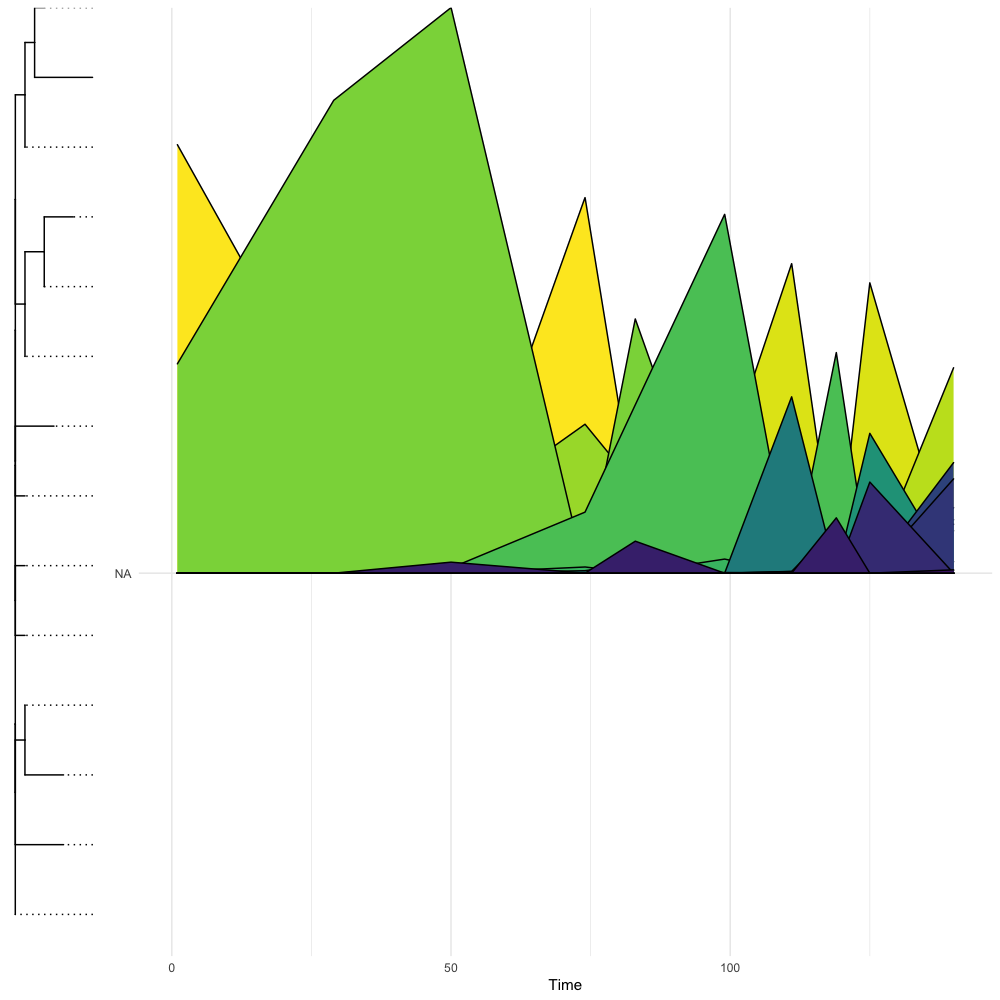

Temporary file deleted successfully.


In [33]:
# create ridgeplot for later joining

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
p <- ridge_plot %>% insert_left(tree_plot, width = 0.1)

# Save the plot with adjusted resolution and dimensions
png(filename = $output_path, width = 1000, height = 1000, res = 100)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)
  
    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
  else
    println("File does not exist.")
  end

